# Test Training on Colab

## Set up

### install required packages

In [31]:
import os
import torch
os.environ['TORCH'] = torch.__version__
os.environ['PYTHONWARNINGS'] = "ignore"
print(torch.__version__)
!pip install torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install git+https://github.com/pyg-team/pytorch_geometric.git
!pip install optuna

2.6.0+cu124
Looking in links: https://data.pyg.org/whl/torch-2.6.0+cu124.html
Looking in links: https://data.pyg.org/whl/torch-2.6.0+cu124.html
  Cloning https://github.com/pyg-team/pytorch_geometric.git to /tmp/pip-req-build-pbfkfnrh
  Running command git clone --filter=blob:none --quiet https://github.com/pyg-team/pytorch_geometric.git /tmp/pip-req-build-pbfkfnrh
  Resolved https://github.com/pyg-team/pytorch_geometric.git to commit 1f0fbe89d654232fdc949d7b947b938671657c31
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


### Import and Var

In [32]:
import warnings
warnings.filterwarnings("ignore")

In [33]:
import os

## Common Functions

In [34]:
import numpy as np
from sklearn.metrics import f1_score

def tune_thresholds(y_true, y_pred_prob, metric='f1'):
    y_true = np.asarray(y_true)          # Fix: convert to NumPy
    y_pred_prob = np.asarray(y_pred_prob)

    best_thresholds = []
    best_scores = []

    for i in range(y_true.shape[1]):
        label_true = y_true[:, i]
        label_probs = y_pred_prob[:, i]  # Fix here too

        thresholds = np.linspace(0.0, 1.0, 101)
        scores = []

        for t in thresholds:
            label_pred = (label_probs >= t).astype(int)
            if metric == 'f1':
                score = f1_score(label_true, label_pred, zero_division=0)
            scores.append(score)

        best_t = thresholds[np.argmax(scores)]
        best_score = np.max(scores)

        best_thresholds.append(best_t)
        best_scores.append(best_score)

        print(f"Label {i}: Best threshold = {best_t}, Best {metric} = {best_score}")

    return best_thresholds, best_scores

In [35]:
from sklearn.metrics import classification_report, multilabel_confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def plot_confusion_matrix(y_test, y_pred, label_cols):
    print(classification_report(y_test, y_pred, target_names=label_cols))
    mcm = multilabel_confusion_matrix(y_test, y_pred)

    n_labels = len(label_cols)
    _, axes = plt.subplots(1, n_labels, figsize=(5 * n_labels, 4))  # 5 units wide per plot

    for i, matrix in enumerate(mcm):
        disp = ConfusionMatrixDisplay(confusion_matrix=matrix, display_labels=['No ' + label_cols[i], label_cols[i]])
        disp.plot(cmap=plt.cm.Blues, ax=axes[i], colorbar=False)
        axes[i].set_title(f'{label_cols[i]}')

    plt.show()

In [36]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_mean_pool

class GCN(nn.Module):
    def __init__(self, in_channels, hidden, out_channels, dropout=0.0):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden)
        self.conv2 = GCNConv(hidden, hidden)
        self.lin = nn.Linear(hidden, out_channels)
        self.dropout = dropout
    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = F.relu(self.conv2(x, edge_index))
        x = global_mean_pool(x, batch)
        return self.lin(x)

In [37]:
from torch_geometric.utils import from_networkx
import pandas as pd
import pickle

def load_data(mode='txn'):
    graph_feature = pd.read_csv(f'{mode}_graph_features.csv', index_col=0)
    graph_feature.index = graph_feature.index.str.lower()
    graphs = pickle.load(open(f'{mode}.pkl', 'rb'))
    y = pd.read_csv('groundtruth.csv', index_col=0)

    label_cols = y.columns.tolist()

    dataset = []
    for i, (address, graph_data) in enumerate(graphs.items()):
        feature = graph_feature.loc[address]
        data = from_networkx(graph_data)

        data.x = torch.tensor(feature, dtype=torch.float32).repeat(data.num_nodes, 1) # Repeat features for each node
        data.y = torch.tensor(y.loc[address][label_cols].values, dtype=torch.float32).unsqueeze(0) # Add a batch dimension
        dataset.append(data)

    return dataset, graph_feature.shape[1], label_cols


In [38]:
def create_trained_model(in_channels, hidden_dim, out_channels, dropout, lr, epochs, train_loader):
    model = GCN(in_channels=in_channels, hidden=hidden_dim, out_channels=out_channels, dropout=dropout)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.BCEWithLogitsLoss()

    model.train()
    for epoch in range(epochs):
        for batch in train_loader:
            optimizer.zero_grad()
            out = model(batch)
            loss = criterion(out, batch.y.float())
            loss.backward()
            optimizer.step()
        print(f'Epoch: {epoch+1}/{epochs}, Loss: {loss.item():.4f}')

    return model

def val_model(model, test_loader, thresholds=None):
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for batch in test_loader:
            out = model(batch)
            prob = (torch.sigmoid(out)).cpu() # Removed .int() here as tune_thresholds expects probabilities
            y_true.append(batch.y.cpu())
            y_pred.append(prob) # Changed preds to prob

    y_true = torch.cat(y_true).numpy()
    y_pred = torch.cat(y_pred).numpy()

    if thresholds is None:
        thresholds, _ = tune_thresholds(y_true, y_pred)

    y_pred = (y_pred > thresholds).astype(int)

    return y_true, y_pred, thresholds

In [39]:
from torch_geometric.loader import DataLoader

def objective(trial, dataset, in_channels, out_channels):
    hidden_dim = trial.suggest_int("hidden_dim", 32, 256)
    lr = trial.suggest_float("lr", 1e-6, 1e-2, log=True)
    dropout = trial.suggest_float("dropout", 0.0, 0.8)
    batch_size = trial.suggest_int("batch_size", 16, 256, log=True)
    epochs = trial.suggest_int("epochs", 5, 50)

    train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

    model = create_trained_model(in_channels, hidden_dim, out_channels, dropout, lr, epochs, train_loader)
    y_true, y_pred, _ = val_model(model, test_loader)

    return f1_score(y_true, y_pred, average='macro')


In [40]:
import torch
import json
import optuna
from functools import partial

def get_trained_gcn_model(mode='txn', n_trials=100, save_path=None):
    dataset, in_channel, label_cols = load_data(mode)
    study = optuna.create_study(direction="maximize")
    objective_partial = partial(objective, dataset=dataset, in_channels=in_channel, out_channels=len(label_cols))
    study.optimize(objective_partial, n_trials=n_trials)
    best_params = study.best_params

    print("Best Params:", study.best_params)
    print("Best Score:", study.best_value)

    best_model = create_trained_model(in_channel, best_params['hidden_dim'], len(label_cols), best_params['dropout'], best_params['lr'], best_params['epochs'], DataLoader(dataset, batch_size=best_params['batch_size'], shuffle=True))

    y_test, y_pred, thresholds = val_model(best_model, DataLoader(dataset, batch_size=best_params['batch_size'], shuffle=False))

    weights = f1_score(y_test, y_pred, average=None)
    if save_path is not None:
        filename = f'{mode}_model.pth'
        torch.save(best_model.state_dict(), os.path.join(save_path, filename))
        print(f"Model saved to {filename}")

        filename = f'{mode}_best_params.json'
        with open(os.path.join(save_path, filename), 'w') as f:
            data = {
                **best_params,
                'in_channels':in_channel,
                'out_channels':len(label_cols),
                'thresholds': thresholds,
                'weights': weights.tolist()
            }
            json.dump(data, f, indent=4)
        print(f"Best parameters saved to {filename}")


    return best_model, thresholds

## Transaction

In [41]:
import torch
from torch_geometric.loader import DataLoader

model, thresholds = get_trained_gcn_model(mode='txn', save_path='.', n_trials=10)

[I 2025-08-02 23:07:11,875] A new study created in memory with name: no-name-7deaeae2-01b8-4500-9455-e910cf2ffb8f


Epoch: 1/43, Loss: 0.7147
Epoch: 2/43, Loss: 0.4665
Epoch: 3/43, Loss: 0.5838
Epoch: 4/43, Loss: 1.3880
Epoch: 5/43, Loss: 0.6684
Epoch: 6/43, Loss: 0.0000
Epoch: 7/43, Loss: 0.5269
Epoch: 8/43, Loss: 0.5725
Epoch: 9/43, Loss: 0.0002
Epoch: 10/43, Loss: 0.7416
Epoch: 11/43, Loss: 0.7307
Epoch: 12/43, Loss: 0.6592
Epoch: 13/43, Loss: 0.6421
Epoch: 14/43, Loss: 0.7714
Epoch: 15/43, Loss: 0.0000
Epoch: 16/43, Loss: 0.6356
Epoch: 17/43, Loss: 0.6479
Epoch: 18/43, Loss: 0.7434
Epoch: 19/43, Loss: 0.6474
Epoch: 20/43, Loss: 0.5414
Epoch: 21/43, Loss: 0.5170
Epoch: 22/43, Loss: 0.5244
Epoch: 23/43, Loss: 0.9479
Epoch: 24/43, Loss: 0.4606
Epoch: 25/43, Loss: 0.6498
Epoch: 26/43, Loss: 0.6742
Epoch: 27/43, Loss: 0.5943
Epoch: 28/43, Loss: 3.1197
Epoch: 29/43, Loss: 0.7879
Epoch: 30/43, Loss: 0.3828
Epoch: 31/43, Loss: 0.5902
Epoch: 32/43, Loss: 0.8239
Epoch: 33/43, Loss: 0.7807
Epoch: 34/43, Loss: 0.5531
Epoch: 35/43, Loss: 0.4884
Epoch: 36/43, Loss: 0.0167
Epoch: 37/43, Loss: 0.5793
Epoch: 38/

[I 2025-08-02 23:07:49,851] Trial 0 finished with value: 0.652738945741656 and parameters: {'hidden_dim': 154, 'lr': 0.0028898317346536953, 'dropout': 0.5570523581386316, 'batch_size': 41, 'epochs': 43}. Best is trial 0 with value: 0.652738945741656.


Label 2: Best threshold = 0.39, Best f1 = 0.5962732919254659
Epoch: 1/24, Loss: 11.9482
Epoch: 2/24, Loss: 12.0624
Epoch: 3/24, Loss: 12.2348
Epoch: 4/24, Loss: 11.9641
Epoch: 5/24, Loss: 12.1497
Epoch: 6/24, Loss: 12.1361
Epoch: 7/24, Loss: 11.9630
Epoch: 8/24, Loss: 12.1622
Epoch: 9/24, Loss: 12.1153
Epoch: 10/24, Loss: 12.2440
Epoch: 11/24, Loss: 12.0463
Epoch: 12/24, Loss: 11.8992
Epoch: 13/24, Loss: 12.1719
Epoch: 14/24, Loss: 11.8785
Epoch: 15/24, Loss: 12.2122
Epoch: 16/24, Loss: 12.1552
Epoch: 17/24, Loss: 11.8682
Epoch: 18/24, Loss: 11.8919
Epoch: 19/24, Loss: 11.8886
Epoch: 20/24, Loss: 12.1124
Epoch: 21/24, Loss: 12.0109
Epoch: 22/24, Loss: 11.8425
Epoch: 23/24, Loss: 12.0649
Epoch: 24/24, Loss: 11.8580
Label 0: Best threshold = 0.13, Best f1 = 0.5906040268456376
Label 1: Best threshold = 0.0, Best f1 = 0.76


[I 2025-08-02 23:08:26,167] Trial 1 finished with value: 0.6433047905577413 and parameters: {'hidden_dim': 146, 'lr': 1.2394429106770791e-06, 'dropout': 0.444189726353914, 'batch_size': 138, 'epochs': 24}. Best is trial 0 with value: 0.652738945741656.


Label 2: Best threshold = 0.01, Best f1 = 0.5793103448275863
Epoch: 1/43, Loss: 13.3798
Epoch: 2/43, Loss: 4.9937
Epoch: 3/43, Loss: 3.7321
Epoch: 4/43, Loss: 3.0800
Epoch: 5/43, Loss: 10.2474
Epoch: 6/43, Loss: 12.2816
Epoch: 7/43, Loss: 1.8348
Epoch: 8/43, Loss: 4.8025
Epoch: 9/43, Loss: 1.2954
Epoch: 10/43, Loss: 1.5869
Epoch: 11/43, Loss: 7.4948
Epoch: 12/43, Loss: 0.7067
Epoch: 13/43, Loss: 1.0926
Epoch: 14/43, Loss: 1.2947
Epoch: 15/43, Loss: 1.0394
Epoch: 16/43, Loss: 3.1384
Epoch: 17/43, Loss: 1.7909
Epoch: 18/43, Loss: 0.8638
Epoch: 19/43, Loss: 0.9790
Epoch: 20/43, Loss: 0.7379
Epoch: 21/43, Loss: 0.6031
Epoch: 22/43, Loss: 1.0001
Epoch: 23/43, Loss: 1.2569
Epoch: 24/43, Loss: 0.6497
Epoch: 25/43, Loss: 0.7167
Epoch: 26/43, Loss: 0.6540
Epoch: 27/43, Loss: 0.7352
Epoch: 28/43, Loss: 0.6218
Epoch: 29/43, Loss: 0.6591
Epoch: 30/43, Loss: 0.6171
Epoch: 31/43, Loss: 0.6906
Epoch: 32/43, Loss: 0.7495
Epoch: 33/43, Loss: 0.7605
Epoch: 34/43, Loss: 0.7582
Epoch: 35/43, Loss: 0.6281


[I 2025-08-02 23:09:25,161] Trial 2 finished with value: 0.6569509996479389 and parameters: {'hidden_dim': 235, 'lr': 1.2446375966667955e-05, 'dropout': 0.37286914305722657, 'batch_size': 37, 'epochs': 43}. Best is trial 2 with value: 0.6569509996479389.


Label 2: Best threshold = 0.01, Best f1 = 0.5822784810126582
Epoch: 1/35, Loss: 8.2874
Epoch: 2/35, Loss: 5.9931
Epoch: 3/35, Loss: 4.4621
Epoch: 4/35, Loss: 3.1246
Epoch: 5/35, Loss: 3.3421
Epoch: 6/35, Loss: 2.9931
Epoch: 7/35, Loss: 2.8264
Epoch: 8/35, Loss: 2.5538
Epoch: 9/35, Loss: 2.4268
Epoch: 10/35, Loss: 1.9934
Epoch: 11/35, Loss: 2.7108
Epoch: 12/35, Loss: 3.1375
Epoch: 13/35, Loss: 2.7539
Epoch: 14/35, Loss: 2.4416
Epoch: 15/35, Loss: 1.7849
Epoch: 16/35, Loss: 1.8861
Epoch: 17/35, Loss: 2.2707
Epoch: 18/35, Loss: 1.8657
Epoch: 19/35, Loss: 1.9579
Epoch: 20/35, Loss: 1.7879
Epoch: 21/35, Loss: 1.6206
Epoch: 22/35, Loss: 1.4704
Epoch: 23/35, Loss: 1.5494
Epoch: 24/35, Loss: 1.6457
Epoch: 25/35, Loss: 1.6725
Epoch: 26/35, Loss: 1.4626
Epoch: 27/35, Loss: 1.5486
Epoch: 28/35, Loss: 0.8709
Epoch: 29/35, Loss: 1.2245
Epoch: 30/35, Loss: 1.4443
Epoch: 31/35, Loss: 1.5993
Epoch: 32/35, Loss: 1.1012
Epoch: 33/35, Loss: 1.1361
Epoch: 34/35, Loss: 1.4160
Epoch: 35/35, Loss: 1.4838
Lab

[I 2025-08-02 23:10:17,718] Trial 3 finished with value: 0.6335360441376824 and parameters: {'hidden_dim': 166, 'lr': 0.0002817491816795501, 'dropout': 0.7842934582323813, 'batch_size': 170, 'epochs': 35}. Best is trial 2 with value: 0.6569509996479389.


Label 2: Best threshold = 0.47000000000000003, Best f1 = 0.5614035087719298
Epoch: 1/33, Loss: 0.5885
Epoch: 2/33, Loss: 0.7344
Epoch: 3/33, Loss: 0.6832
Epoch: 4/33, Loss: 0.7722
Epoch: 5/33, Loss: 45.7317
Epoch: 6/33, Loss: 0.6402
Epoch: 7/33, Loss: 0.6212
Epoch: 8/33, Loss: 10.3763
Epoch: 9/33, Loss: 1.2011
Epoch: 10/33, Loss: 0.9882
Epoch: 11/33, Loss: 0.5128
Epoch: 12/33, Loss: 1.4179
Epoch: 13/33, Loss: 1.3246
Epoch: 14/33, Loss: 0.8377
Epoch: 15/33, Loss: 0.8685
Epoch: 16/33, Loss: 0.4877
Epoch: 17/33, Loss: 0.7108
Epoch: 18/33, Loss: 2.1143
Epoch: 19/33, Loss: 0.6451
Epoch: 20/33, Loss: 0.9337
Epoch: 21/33, Loss: 1.6471
Epoch: 22/33, Loss: 0.2613
Epoch: 23/33, Loss: 1.6717
Epoch: 24/33, Loss: 0.6409
Epoch: 25/33, Loss: 0.6442
Epoch: 26/33, Loss: 2.4032
Epoch: 27/33, Loss: 0.5115
Epoch: 28/33, Loss: 0.5469
Epoch: 29/33, Loss: 0.7942
Epoch: 30/33, Loss: 0.9040
Epoch: 31/33, Loss: 0.7030
Epoch: 32/33, Loss: 1.4134
Epoch: 33/33, Loss: 0.6139
Label 0: Best threshold = 0.05, Best f1 

[I 2025-08-02 23:11:31,879] Trial 4 finished with value: 0.6456882717856381 and parameters: {'hidden_dim': 254, 'lr': 9.838526394978379e-06, 'dropout': 0.570242036086208, 'batch_size': 61, 'epochs': 33}. Best is trial 2 with value: 0.6569509996479389.


Label 2: Best threshold = 0.01, Best f1 = 0.581081081081081
Epoch: 1/25, Loss: 2.7680
Epoch: 2/25, Loss: 3.6893
Epoch: 3/25, Loss: 1.1773
Epoch: 4/25, Loss: 1.0656
Epoch: 5/25, Loss: 1.3108
Epoch: 6/25, Loss: 2.3112
Epoch: 7/25, Loss: 0.8881
Epoch: 8/25, Loss: 2.3168
Epoch: 9/25, Loss: 1.0394
Epoch: 10/25, Loss: 1.0022
Epoch: 11/25, Loss: 2.4427
Epoch: 12/25, Loss: 0.8005
Epoch: 13/25, Loss: 1.1305
Epoch: 14/25, Loss: 0.9120
Epoch: 15/25, Loss: 1.1164
Epoch: 16/25, Loss: 0.8946
Epoch: 17/25, Loss: 1.1032
Epoch: 18/25, Loss: 0.8036
Epoch: 19/25, Loss: 1.6418
Epoch: 20/25, Loss: 0.8388
Epoch: 21/25, Loss: 0.7565
Epoch: 22/25, Loss: 0.9850
Epoch: 23/25, Loss: 0.9245
Epoch: 24/25, Loss: 1.8173
Epoch: 25/25, Loss: 0.9094
Label 0: Best threshold = 0.2, Best f1 = 0.589041095890411
Label 1: Best threshold = 0.0, Best f1 = 0.76


[I 2025-08-02 23:11:45,507] Trial 5 finished with value: 0.6379156594144507 and parameters: {'hidden_dim': 109, 'lr': 0.000122779203557621, 'dropout': 0.6662064695602266, 'batch_size': 80, 'epochs': 25}. Best is trial 2 with value: 0.6569509996479389.


Label 2: Best threshold = 0.47000000000000003, Best f1 = 0.5647058823529412
Epoch: 1/6, Loss: 0.7077
Epoch: 2/6, Loss: 4.6500
Epoch: 3/6, Loss: 148.1746
Epoch: 4/6, Loss: 114.0845
Epoch: 5/6, Loss: 0.4599
Epoch: 6/6, Loss: 1.0440
Label 0: Best threshold = 0.0, Best f1 = 0.5581395348837209
Label 1: Best threshold = 0.0, Best f1 = 0.76
Label 2: Best threshold = 0.0, Best f1 = 0.5581395348837209


[I 2025-08-02 23:11:50,879] Trial 6 finished with value: 0.6254263565891472 and parameters: {'hidden_dim': 175, 'lr': 1.2610420068797737e-06, 'dropout': 0.24779033643396603, 'batch_size': 30, 'epochs': 6}. Best is trial 2 with value: 0.6569509996479389.


Epoch: 1/9, Loss: 5.3969
Epoch: 2/9, Loss: 9.5527
Epoch: 3/9, Loss: 0.6207
Epoch: 4/9, Loss: 2.8925
Epoch: 5/9, Loss: 1.1424
Epoch: 6/9, Loss: 0.6443
Epoch: 7/9, Loss: 0.6353
Epoch: 8/9, Loss: 0.6205
Epoch: 9/9, Loss: 0.6783
Label 0: Best threshold = 0.47000000000000003, Best f1 = 0.5695364238410596


[I 2025-08-02 23:11:54,817] Trial 7 finished with value: 0.6303133108709965 and parameters: {'hidden_dim': 92, 'lr': 0.008138894299455175, 'dropout': 0.16872915869793514, 'batch_size': 18, 'epochs': 9}. Best is trial 2 with value: 0.6569509996479389.


Label 1: Best threshold = 0.0, Best f1 = 0.76
Label 2: Best threshold = 0.47000000000000003, Best f1 = 0.5614035087719298
Epoch: 1/8, Loss: 0.9188
Epoch: 2/8, Loss: 1.7037
Epoch: 3/8, Loss: 2.9360
Epoch: 4/8, Loss: 0.5273
Epoch: 5/8, Loss: 0.9898
Epoch: 6/8, Loss: 0.8610
Epoch: 7/8, Loss: 3.0834
Epoch: 8/8, Loss: 0.7084
Label 0: Best threshold = 0.0, Best f1 = 0.5581395348837209
Label 1: Best threshold = 0.1, Best f1 = 0.7636363636363637


[I 2025-08-02 23:12:06,341] Trial 8 finished with value: 0.6266384778012686 and parameters: {'hidden_dim': 195, 'lr': 0.0004445511417609628, 'dropout': 0.5556818626302962, 'batch_size': 24, 'epochs': 8}. Best is trial 2 with value: 0.6569509996479389.


Label 2: Best threshold = 0.0, Best f1 = 0.5581395348837209
Epoch: 1/7, Loss: 2.8624
Epoch: 2/7, Loss: 9.4292
Epoch: 3/7, Loss: 4.4840
Epoch: 4/7, Loss: 0.8910
Epoch: 5/7, Loss: 0.6644
Epoch: 6/7, Loss: 1.7964
Epoch: 7/7, Loss: 0.8981
Label 0: Best threshold = 0.48, Best f1 = 0.5974025974025974
Label 1: Best threshold = 0.19, Best f1 = 0.7835051546391752


[I 2025-08-02 23:12:10,723] Trial 9 finished with value: 0.6585007822121224 and parameters: {'hidden_dim': 113, 'lr': 0.0008490214961620457, 'dropout': 0.5429364323846421, 'batch_size': 21, 'epochs': 7}. Best is trial 9 with value: 0.6585007822121224.


Label 2: Best threshold = 0.23, Best f1 = 0.5945945945945946
Best Params: {'hidden_dim': 113, 'lr': 0.0008490214961620457, 'dropout': 0.5429364323846421, 'batch_size': 21, 'epochs': 7}
Best Score: 0.6585007822121224
Epoch: 1/7, Loss: 1.4835
Epoch: 2/7, Loss: 14.8201
Epoch: 3/7, Loss: 3.8650
Epoch: 4/7, Loss: 0.9036
Epoch: 5/7, Loss: 1.0107
Epoch: 6/7, Loss: 0.7172
Epoch: 7/7, Loss: 1.6744
Label 0: Best threshold = 0.02, Best f1 = 0.581081081081081
Label 1: Best threshold = 0.01, Best f1 = 0.7717391304347826
Label 2: Best threshold = 0.06, Best f1 = 0.5850340136054422
Model saved to txn_model.pth
Best parameters saved to txn_best_params.json


Label 0: Best threshold = 0.02, Best f1 = 0.581081081081081
Label 1: Best threshold = 0.01, Best f1 = 0.7717391304347826
Label 2: Best threshold = 0.06, Best f1 = 0.5850340136054422
              precision    recall  f1-score   support

        Mint       0.43      0.90      0.58        48
        Leak       0.66      0.93      0.77        76
       Limit       0.43      0.90      0.59        48

   micro avg       0.51      0.91      0.66       172
   macro avg       0.51      0.91      0.65       172
weighted avg       0.53      0.91      0.67       172
 samples avg       0.44      0.71      0.52       172



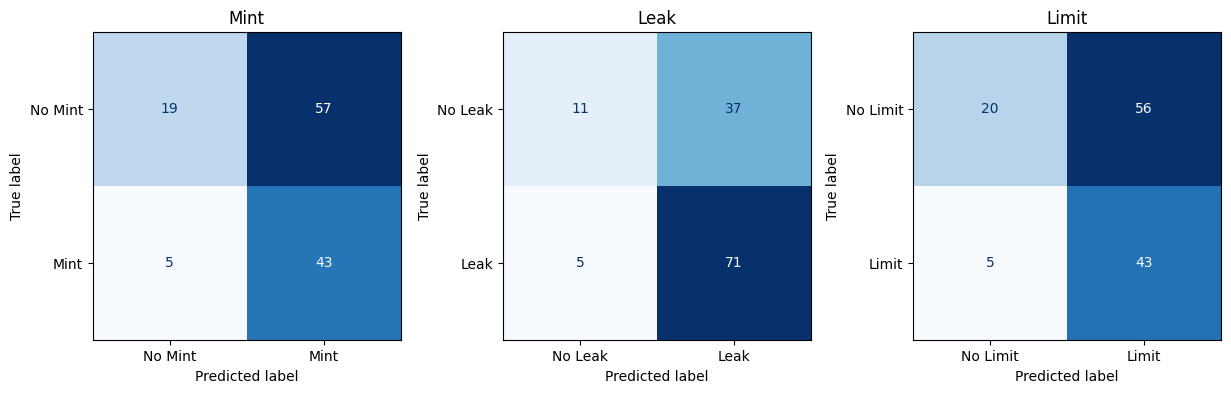

In [42]:
dataset = load_data(mode='txn')[0]
loader = DataLoader(dataset, batch_size=128, shuffle=True)
ground_df = pd.read_csv('groundtruth.csv', index_col=0)
label_cols = ground_df.columns.tolist()
y_true, y_pred, _ = val_model(model, loader)

plot_confusion_matrix(y_true, y_pred, label_cols)

              precision    recall  f1-score   support

        Mint       0.43      0.90      0.58        48
        Leak       0.66      0.93      0.77        76
       Limit       0.43      0.90      0.59        48

   micro avg       0.51      0.91      0.66       172
   macro avg       0.51      0.91      0.65       172
weighted avg       0.53      0.91      0.67       172
 samples avg       0.44      0.71      0.52       172



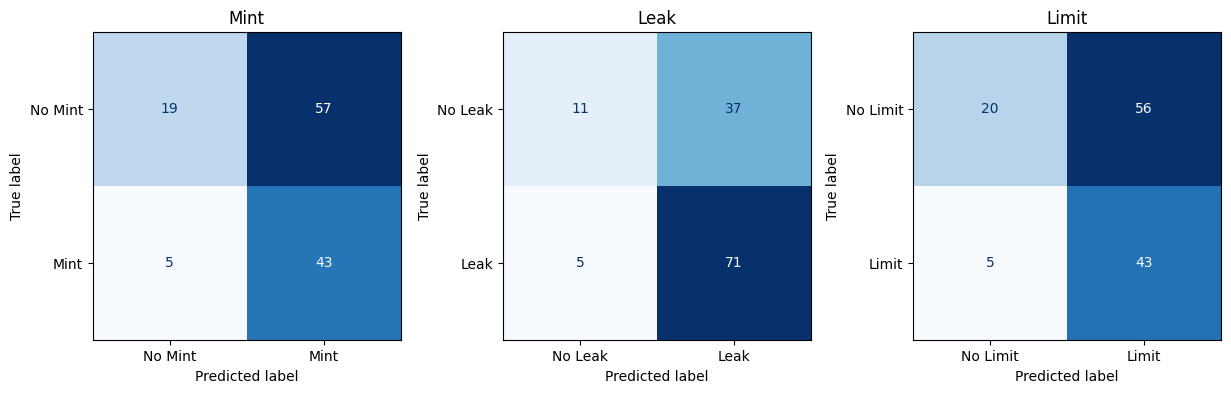

In [43]:
import torch
import json

# Load best parameters
with open("txn_best_params.json", "r") as f:
    best_params = json.load(f)

# Get input and output channels (assuming they are consistent with training)
dataset_info, in_channels, label_cols = load_data(mode='txn')
out_channels = len(label_cols)

# Initialize the model with the loaded parameters
loaded_model = GCN(in_channels=in_channels, hidden=best_params['hidden_dim'], out_channels=out_channels, dropout=best_params['dropout'])

# Load the state dictionary
loaded_model.load_state_dict(torch.load("txn_model.pth"))

thresholds = best_params['thresholds']
# Assuming 'loader' and 'thresholds' are already defined from previous cells
y_true, y_pred, _ = val_model(loaded_model, loader, thresholds)

plot_confusion_matrix(y_true, y_pred, label_cols)

## Control Flow

In [44]:
import torch
from torch_geometric.loader import DataLoader

model, thresholds = get_trained_gcn_model(mode='cfg', save_path='.', n_trials=10)

[I 2025-08-02 23:12:27,752] A new study created in memory with name: no-name-2bffcd93-e402-4111-a9a7-57a60bfe973c


Epoch: 1/50, Loss: 6.3507
Epoch: 2/50, Loss: 2.6804
Epoch: 3/50, Loss: 2.7144
Epoch: 4/50, Loss: 3.1983
Epoch: 5/50, Loss: 2.6864
Epoch: 6/50, Loss: 1.7499
Epoch: 7/50, Loss: 1.0818
Epoch: 8/50, Loss: 1.6756
Epoch: 9/50, Loss: 2.0819
Epoch: 10/50, Loss: 1.7409
Epoch: 11/50, Loss: 1.1283
Epoch: 12/50, Loss: 0.9647
Epoch: 13/50, Loss: 1.3013
Epoch: 14/50, Loss: 1.4103
Epoch: 15/50, Loss: 1.2646
Epoch: 16/50, Loss: 0.9883
Epoch: 17/50, Loss: 0.7143
Epoch: 18/50, Loss: 0.8810
Epoch: 19/50, Loss: 1.0653
Epoch: 20/50, Loss: 0.9566
Epoch: 21/50, Loss: 0.7258
Epoch: 22/50, Loss: 0.7013
Epoch: 23/50, Loss: 0.8508
Epoch: 24/50, Loss: 0.9038
Epoch: 25/50, Loss: 0.8025
Epoch: 26/50, Loss: 0.6531
Epoch: 27/50, Loss: 0.7106
Epoch: 28/50, Loss: 0.8077
Epoch: 29/50, Loss: 0.7440
Epoch: 30/50, Loss: 0.6357
Epoch: 31/50, Loss: 0.6771
Epoch: 32/50, Loss: 0.7314
Epoch: 33/50, Loss: 0.7068
Epoch: 34/50, Loss: 0.6390
Epoch: 35/50, Loss: 0.6531
Epoch: 36/50, Loss: 0.6832
Epoch: 37/50, Loss: 0.6584
Epoch: 38/

[I 2025-08-02 23:13:21,451] Trial 0 finished with value: 0.7020717377860235 and parameters: {'hidden_dim': 179, 'lr': 0.001658354080549806, 'dropout': 0.16128755084293964, 'batch_size': 193, 'epochs': 50}. Best is trial 0 with value: 0.7020717377860235.


Label 1: Best threshold = 0.73, Best f1 = 0.8409090909090909
Label 2: Best threshold = 0.39, Best f1 = 0.6224489795918368
Epoch: 1/39, Loss: 6.8351
Epoch: 2/39, Loss: 5.2963
Epoch: 3/39, Loss: 6.1681
Epoch: 4/39, Loss: 5.7640
Epoch: 5/39, Loss: 6.0626
Epoch: 6/39, Loss: 4.7701
Epoch: 7/39, Loss: 4.6961
Epoch: 8/39, Loss: 5.0384
Epoch: 9/39, Loss: 5.3642
Epoch: 10/39, Loss: 5.0948
Epoch: 11/39, Loss: 5.2454
Epoch: 12/39, Loss: 5.9074
Epoch: 13/39, Loss: 5.6128
Epoch: 14/39, Loss: 5.9451
Epoch: 15/39, Loss: 5.6378
Epoch: 16/39, Loss: 4.6671
Epoch: 17/39, Loss: 5.3032
Epoch: 18/39, Loss: 5.7063
Epoch: 19/39, Loss: 5.8621
Epoch: 20/39, Loss: 5.7876
Epoch: 21/39, Loss: 5.7709
Epoch: 22/39, Loss: 5.5952
Epoch: 23/39, Loss: 5.5711
Epoch: 24/39, Loss: 5.7152
Epoch: 25/39, Loss: 4.6637
Epoch: 26/39, Loss: 4.6707
Epoch: 27/39, Loss: 5.2714
Epoch: 28/39, Loss: 5.2200
Epoch: 29/39, Loss: 4.5653
Epoch: 30/39, Loss: 4.9989
Epoch: 31/39, Loss: 5.4743
Epoch: 32/39, Loss: 4.9990
Epoch: 33/39, Loss: 5.9

[I 2025-08-02 23:13:38,017] Trial 1 finished with value: 0.6372228307712179 and parameters: {'hidden_dim': 138, 'lr': 2.100159404846155e-06, 'dropout': 0.147548249990445, 'batch_size': 78, 'epochs': 39}. Best is trial 0 with value: 0.7020717377860235.


Label 2: Best threshold = 0.0, Best f1 = 0.5806451612903226
Epoch: 1/26, Loss: 4.6750
Epoch: 2/26, Loss: 1.1435
Epoch: 3/26, Loss: 1.3460
Epoch: 4/26, Loss: 2.7020
Epoch: 5/26, Loss: 1.9069
Epoch: 6/26, Loss: 0.9667
Epoch: 7/26, Loss: 1.7270
Epoch: 8/26, Loss: 1.4017
Epoch: 9/26, Loss: 2.0393
Epoch: 10/26, Loss: 1.2974
Epoch: 11/26, Loss: 1.6642
Epoch: 12/26, Loss: 0.6828
Epoch: 13/26, Loss: 1.1559
Epoch: 14/26, Loss: 0.8684
Epoch: 15/26, Loss: 0.7398
Epoch: 16/26, Loss: 0.8383
Epoch: 17/26, Loss: 0.9150
Epoch: 18/26, Loss: 0.6928
Epoch: 19/26, Loss: 0.6564
Epoch: 20/26, Loss: 0.7998
Epoch: 21/26, Loss: 0.7102
Epoch: 22/26, Loss: 0.8106
Epoch: 23/26, Loss: 0.7725
Epoch: 24/26, Loss: 0.9069
Epoch: 25/26, Loss: 0.6939
Epoch: 26/26, Loss: 0.9168
Label 0: Best threshold = 0.01, Best f1 = 0.5714285714285714
Label 1: Best threshold = 0.79, Best f1 = 0.7488584474885844


[I 2025-08-02 23:13:44,741] Trial 2 finished with value: 0.6367623396390519 and parameters: {'hidden_dim': 75, 'lr': 0.0010773122793126559, 'dropout': 0.31427697170196506, 'batch_size': 146, 'epochs': 26}. Best is trial 0 with value: 0.7020717377860235.


Label 2: Best threshold = 0.64, Best f1 = 0.59
Epoch: 1/13, Loss: 3.4322
Epoch: 2/13, Loss: 2.4834
Epoch: 3/13, Loss: 1.5355
Epoch: 4/13, Loss: 1.1487
Epoch: 5/13, Loss: 1.3208
Epoch: 6/13, Loss: 1.3129
Epoch: 7/13, Loss: 1.0254
Epoch: 8/13, Loss: 0.8419
Epoch: 9/13, Loss: 0.9450
Epoch: 10/13, Loss: 1.0226
Epoch: 11/13, Loss: 0.9012
Epoch: 12/13, Loss: 0.7699
Epoch: 13/13, Loss: 0.7623
Label 0: Best threshold = 0.55, Best f1 = 0.6164383561643836
Label 1: Best threshold = 0.39, Best f1 = 0.7953216374269005


[I 2025-08-02 23:13:57,158] Trial 3 finished with value: 0.6641350516272023 and parameters: {'hidden_dim': 221, 'lr': 0.00017610254585275376, 'dropout': 0.7307121444455174, 'batch_size': 97, 'epochs': 13}. Best is trial 0 with value: 0.7020717377860235.


Label 2: Best threshold = 0.0, Best f1 = 0.5806451612903226
Epoch: 1/48, Loss: 6.2490
Epoch: 2/48, Loss: 1.0732
Epoch: 3/48, Loss: 5.2414
Epoch: 4/48, Loss: 7.0125
Epoch: 5/48, Loss: 1.4439
Epoch: 6/48, Loss: 4.6887
Epoch: 7/48, Loss: 4.0220
Epoch: 8/48, Loss: 4.9696
Epoch: 9/48, Loss: 3.1978
Epoch: 10/48, Loss: 2.3421
Epoch: 11/48, Loss: 3.8502
Epoch: 12/48, Loss: 3.3207
Epoch: 13/48, Loss: 2.5926
Epoch: 14/48, Loss: 1.8724
Epoch: 15/48, Loss: 1.9704
Epoch: 16/48, Loss: 1.6935
Epoch: 17/48, Loss: 1.5034
Epoch: 18/48, Loss: 1.3247
Epoch: 19/48, Loss: 0.8265
Epoch: 20/48, Loss: 0.8918
Epoch: 21/48, Loss: 1.1739
Epoch: 22/48, Loss: 0.8508
Epoch: 23/48, Loss: 0.9733
Epoch: 24/48, Loss: 0.9222
Epoch: 25/48, Loss: 0.9017
Epoch: 26/48, Loss: 0.8442
Epoch: 27/48, Loss: 0.6644
Epoch: 28/48, Loss: 0.9894
Epoch: 29/48, Loss: 0.9984
Epoch: 30/48, Loss: 0.8433
Epoch: 31/48, Loss: 0.7135
Epoch: 32/48, Loss: 0.6897
Epoch: 33/48, Loss: 0.7477
Epoch: 34/48, Loss: 0.5607
Epoch: 35/48, Loss: 0.7423
Epoc

[I 2025-08-02 23:14:19,838] Trial 4 finished with value: 0.6509947033355 and parameters: {'hidden_dim': 147, 'lr': 2.5835287898355017e-05, 'dropout': 0.06649940734190062, 'batch_size': 48, 'epochs': 48}. Best is trial 0 with value: 0.7020717377860235.


Label 2: Best threshold = 0.37, Best f1 = 0.5933014354066986
Epoch: 1/13, Loss: 3.7199
Epoch: 2/13, Loss: 3.0437
Epoch: 3/13, Loss: 6.0164
Epoch: 4/13, Loss: 1.5282
Epoch: 5/13, Loss: 2.2261
Epoch: 6/13, Loss: 1.1229
Epoch: 7/13, Loss: 1.5996
Epoch: 8/13, Loss: 0.7007
Epoch: 9/13, Loss: 1.2523
Epoch: 10/13, Loss: 0.4874
Epoch: 11/13, Loss: 1.2506
Epoch: 12/13, Loss: 0.6053
Epoch: 13/13, Loss: 1.1197
Label 0: Best threshold = 0.02, Best f1 = 0.5529411764705883
Label 1: Best threshold = 0.43, Best f1 = 0.7672955974842768
Label 2: Best threshold = 0.93, Best f1 = 0.6078431372549019


[I 2025-08-02 23:14:23,663] Trial 5 finished with value: 0.6426933037365891 and parameters: {'hidden_dim': 92, 'lr': 0.000560020686502613, 'dropout': 0.7108630764349376, 'batch_size': 74, 'epochs': 13}. Best is trial 0 with value: 0.7020717377860235.


Epoch: 1/49, Loss: 3.2883
Epoch: 2/49, Loss: 1.7959
Epoch: 3/49, Loss: 0.7033
Epoch: 4/49, Loss: 1.0126
Epoch: 5/49, Loss: 0.7584
Epoch: 6/49, Loss: 0.7447
Epoch: 7/49, Loss: 0.7846
Epoch: 8/49, Loss: 0.7169
Epoch: 9/49, Loss: 1.2003
Epoch: 10/49, Loss: 0.7990
Epoch: 11/49, Loss: 0.8777
Epoch: 12/49, Loss: 0.8186
Epoch: 13/49, Loss: 1.0524
Epoch: 14/49, Loss: 0.7337
Epoch: 15/49, Loss: 1.0736
Epoch: 16/49, Loss: 0.9726
Epoch: 17/49, Loss: 0.8123
Epoch: 18/49, Loss: 0.6690
Epoch: 19/49, Loss: 0.8790
Epoch: 20/49, Loss: 0.9508
Epoch: 21/49, Loss: 0.8498
Epoch: 22/49, Loss: 0.6654
Epoch: 23/49, Loss: 0.6330
Epoch: 24/49, Loss: 0.7704
Epoch: 25/49, Loss: 0.7122
Epoch: 26/49, Loss: 0.9143
Epoch: 27/49, Loss: 0.7115
Epoch: 28/49, Loss: 0.5487
Epoch: 29/49, Loss: 0.5538
Epoch: 30/49, Loss: 0.6071
Epoch: 31/49, Loss: 0.7246
Epoch: 32/49, Loss: 0.7087
Epoch: 33/49, Loss: 0.6872
Epoch: 34/49, Loss: 0.5740
Epoch: 35/49, Loss: 0.6200
Epoch: 36/49, Loss: 0.5707
Epoch: 37/49, Loss: 0.6515
Epoch: 38/

[I 2025-08-02 23:14:33,677] Trial 6 finished with value: 0.6679956787426415 and parameters: {'hidden_dim': 63, 'lr': 0.001705433922374078, 'dropout': 0.37310813503933327, 'batch_size': 20, 'epochs': 49}. Best is trial 0 with value: 0.7020717377860235.


Label 2: Best threshold = 0.0, Best f1 = 0.5806451612903226
Epoch: 1/38, Loss: 1.7906
Epoch: 2/38, Loss: 2.2298
Epoch: 3/38, Loss: 1.3231
Epoch: 4/38, Loss: 0.6419
Epoch: 5/38, Loss: 0.5692
Epoch: 6/38, Loss: 0.6954
Epoch: 7/38, Loss: 0.6477
Epoch: 8/38, Loss: 0.6766
Epoch: 9/38, Loss: 0.5514
Epoch: 10/38, Loss: 0.7170
Epoch: 11/38, Loss: 0.7078
Epoch: 12/38, Loss: 0.6591
Epoch: 13/38, Loss: 0.6656
Epoch: 14/38, Loss: 0.6661
Epoch: 15/38, Loss: 0.6826
Epoch: 16/38, Loss: 0.5897
Epoch: 17/38, Loss: 0.6894
Epoch: 18/38, Loss: 0.6023
Epoch: 19/38, Loss: 0.5721
Epoch: 20/38, Loss: 0.5744
Epoch: 21/38, Loss: 0.5910
Epoch: 22/38, Loss: 0.5881
Epoch: 23/38, Loss: 0.6299
Epoch: 24/38, Loss: 0.5560
Epoch: 25/38, Loss: 0.6270
Epoch: 26/38, Loss: 0.6046
Epoch: 27/38, Loss: 0.5560
Epoch: 28/38, Loss: 0.6074
Epoch: 29/38, Loss: 0.6422
Epoch: 30/38, Loss: 0.6260
Epoch: 31/38, Loss: 0.6224
Epoch: 32/38, Loss: 0.5963
Epoch: 33/38, Loss: 0.6451
Epoch: 34/38, Loss: 0.5830
Epoch: 35/38, Loss: 0.5833
Epoc

[I 2025-08-02 23:14:44,714] Trial 7 finished with value: 0.6676112479942758 and parameters: {'hidden_dim': 95, 'lr': 0.006920736215438599, 'dropout': 0.424656219249937, 'batch_size': 27, 'epochs': 38}. Best is trial 0 with value: 0.7020717377860235.


Label 2: Best threshold = 0.19, Best f1 = 0.5990338164251208
Epoch: 1/17, Loss: 3.5205
Epoch: 2/17, Loss: 3.6210
Epoch: 3/17, Loss: 3.1197
Epoch: 4/17, Loss: 2.4948
Epoch: 5/17, Loss: 1.4587
Epoch: 6/17, Loss: 2.1757
Epoch: 7/17, Loss: 1.7847
Epoch: 8/17, Loss: 2.0307
Epoch: 9/17, Loss: 1.8107
Epoch: 10/17, Loss: 1.3093
Epoch: 11/17, Loss: 1.4498
Epoch: 12/17, Loss: 1.1892
Epoch: 13/17, Loss: 0.9606
Epoch: 14/17, Loss: 0.9938
Epoch: 15/17, Loss: 0.7841
Epoch: 16/17, Loss: 0.8143
Epoch: 17/17, Loss: 0.8487
Label 0: Best threshold = 0.01, Best f1 = 0.5656565656565656


[I 2025-08-02 23:14:51,222] Trial 8 finished with value: 0.6276231927484576 and parameters: {'hidden_dim': 126, 'lr': 7.88037497703192e-05, 'dropout': 0.23547664577246197, 'batch_size': 64, 'epochs': 17}. Best is trial 0 with value: 0.7020717377860235.


Label 1: Best threshold = 0.19, Best f1 = 0.7256637168141593
Label 2: Best threshold = 0.5700000000000001, Best f1 = 0.5915492957746479
Epoch: 1/8, Loss: 17.0155
Epoch: 2/8, Loss: 17.0348
Epoch: 3/8, Loss: 17.0737
Epoch: 4/8, Loss: 17.0479
Epoch: 5/8, Loss: 17.0878
Epoch: 6/8, Loss: 16.8410
Epoch: 7/8, Loss: 16.9052
Epoch: 8/8, Loss: 16.9170
Label 0: Best threshold = 0.0, Best f1 = 0.5402843601895735
Label 1: Best threshold = 0.98, Best f1 = 0.7124463519313304


[I 2025-08-02 23:14:52,724] Trial 9 finished with value: 0.4175769040403013 and parameters: {'hidden_dim': 33, 'lr': 1.9771588517300903e-05, 'dropout': 0.6655186250419938, 'batch_size': 201, 'epochs': 8}. Best is trial 0 with value: 0.7020717377860235.


Label 2: Best threshold = 1.0, Best f1 = 0.5990338164251208
Best Params: {'hidden_dim': 179, 'lr': 0.001658354080549806, 'dropout': 0.16128755084293964, 'batch_size': 193, 'epochs': 50}
Best Score: 0.7020717377860235
Epoch: 1/50, Loss: 5.4307
Epoch: 2/50, Loss: 1.7660
Epoch: 3/50, Loss: 3.1303
Epoch: 4/50, Loss: 1.8004
Epoch: 5/50, Loss: 1.1865
Epoch: 6/50, Loss: 1.9967
Epoch: 7/50, Loss: 1.8551
Epoch: 8/50, Loss: 1.5987
Epoch: 9/50, Loss: 1.3561
Epoch: 10/50, Loss: 0.9904
Epoch: 11/50, Loss: 1.0189
Epoch: 12/50, Loss: 1.3618
Epoch: 13/50, Loss: 1.1689
Epoch: 14/50, Loss: 0.7590
Epoch: 15/50, Loss: 0.9089
Epoch: 16/50, Loss: 0.9982
Epoch: 17/50, Loss: 0.9546
Epoch: 18/50, Loss: 0.9635
Epoch: 19/50, Loss: 0.7983
Epoch: 20/50, Loss: 0.6581
Epoch: 21/50, Loss: 0.8338
Epoch: 22/50, Loss: 0.8953
Epoch: 23/50, Loss: 0.6974
Epoch: 24/50, Loss: 0.6818
Epoch: 25/50, Loss: 0.7909
Epoch: 26/50, Loss: 0.7922
Epoch: 27/50, Loss: 0.7266
Epoch: 28/50, Loss: 0.6628
Epoch: 29/50, Loss: 0.6539
Epoch: 30

              precision    recall  f1-score   support

        Mint       0.45      0.93      0.61        57
        Leak       0.75      0.83      0.79        83
       Limit       0.45      0.98      0.61        63

   micro avg       0.53      0.91      0.67       203
   macro avg       0.55      0.92      0.67       203
weighted avg       0.57      0.91      0.68       203
 samples avg       0.49      0.70      0.54       203



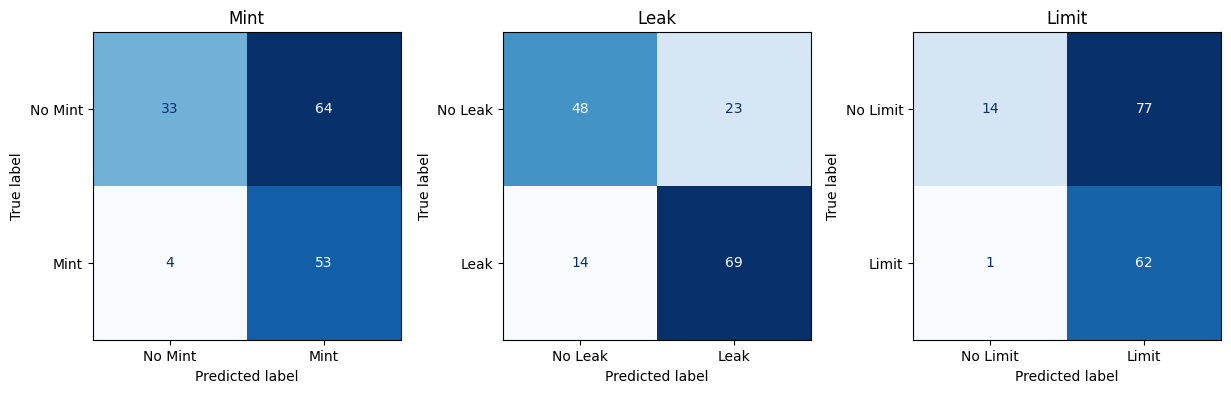

In [45]:
dataset = load_data(mode='cfg')[0]
loader = DataLoader(dataset, batch_size=128, shuffle=True)
y_true, y_pred, _ = val_model(model, loader, thresholds)

plot_confusion_matrix(y_true, y_pred, label_cols)

              precision    recall  f1-score   support

        Mint       0.45      0.93      0.61        57
        Leak       0.75      0.83      0.79        83
       Limit       0.45      0.98      0.61        63

   micro avg       0.53      0.91      0.67       203
   macro avg       0.55      0.92      0.67       203
weighted avg       0.57      0.91      0.68       203
 samples avg       0.49      0.70      0.54       203



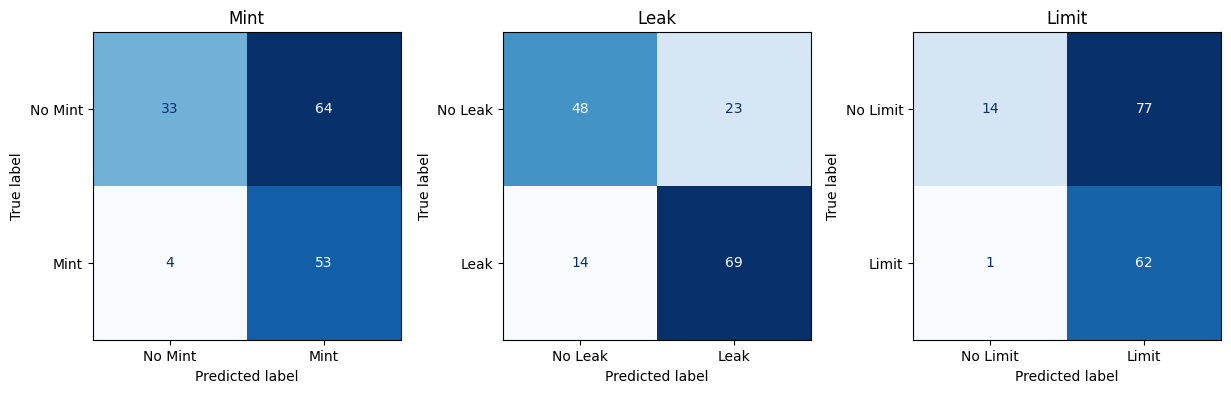

In [46]:
import torch
import json

# Load best parameters
with open("cfg_best_params.json", "r") as f:
    best_params = json.load(f)

# Get input and output channels (assuming they are consistent with training)
dataset_info, in_channels, label_cols = load_data(mode='txn')
out_channels = len(label_cols)

# Initialize the model with the loaded parameters
loaded_model = GCN(in_channels=in_channels, hidden=best_params['hidden_dim'], out_channels=out_channels, dropout=best_params['dropout'])

# Load the state dictionary
loaded_model.load_state_dict(torch.load("cfg_model.pth"))

thresholds = best_params['thresholds']
# Assuming 'loader' and 'thresholds' are already defined from previous cells
y_true, y_pred, _ = val_model(loaded_model, loader, thresholds)

plot_confusion_matrix(y_true, y_pred, label_cols)